In [1]:
import time
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
import gluoncv as gcv
from gluoncv.utils import download, viz
from mxnet import autograd, contrib, gluon, image, init, nd
from mxnet.gluon import loss as gloss, nn, utils as gutils
import os
from gluoncv.utils.metrics.voc_detection import VOC07MApMetric
from gluoncv.data.batchify import Tuple, Stack, Pad
from mxnet.gluon.data import DataLoader
from gluoncv.data.batchify import Tuple, Stack, Pad
from gluoncv.data.transforms.presets.yolo import YOLO3DefaultTrainTransform
from gluoncv.data.transforms.presets.yolo import YOLO3DefaultValTransform
from gluoncv.data.dataloader import RandomTransformDataLoader
from gluoncv.utils import LRScheduler, LRSequential

In [2]:
def save_params(net, best_map, current_map, epoch, save_interval, prefix):
    current_map = float(current_map)
    if current_map > best_map[0]:
        best_map[0] = current_map
        net.save_parameters('{:s}_best.params'.format(prefix, epoch, current_map))
        with open(prefix+'_best_map.log', 'a') as f:
            f.write('{:04d}:\t{:.4f}\n'.format(epoch, current_map))
    if save_interval and epoch % save_interval == 0:
        net.save_parameters('{:s}_{:04d}_{:.4f}.params'.format(prefix, epoch, current_map))
        
def validate(net, val_data, ctx, eval_metric):
    """Test on validation dataset."""
    eval_metric.reset()
    # set nms threshold and topk constraint
    net.set_nms(nms_thresh=0.45, nms_topk=400)
    nd.waitall()
    net.hybridize()
    
    for batch in val_data:
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        det_bboxes = []
        det_ids = []
        det_scores = []
        gt_bboxes = []
        gt_ids = []
        gt_difficults = []
        for x, y in zip(data, label):
            # get prediction results
            ids, scores, bboxes = net(x)
            det_ids.append(ids)
            det_scores.append(scores)
            # clip to image size
            det_bboxes.append(bboxes.clip(0, batch[0].shape[2]))
            # split ground truths
            gt_ids.append(y.slice_axis(axis=-1, begin=4, end=5))
            gt_bboxes.append(y.slice_axis(axis=-1, begin=0, end=4))
            gt_difficults.append(y.slice_axis(axis=-1, begin=5, end=6) if y.shape[-1] > 5 else None)

        # update metric
        eval_metric.update(det_bboxes, det_ids, det_scores, gt_bboxes, gt_ids, gt_difficults)
    return eval_metric.get()

val_metric = VOC07MApMetric(iou_thresh=0.5, class_names=["truck", "car", "van", "bus"])

label: [[5.7894403e+02 3.0499200e+02 5.8995203e+02 3.2198401e+02 1.0000000e+00
  0.0000000e+00]
 [5.6793597e+02 3.0600000e+02 5.7894403e+02 3.2299200e+02 1.0000000e+00
  0.0000000e+00]
 [5.4502399e+02 3.0398401e+02 5.6998401e+02 3.2702399e+02 1.0000000e+00
  0.0000000e+00]
 [5.1494397e+02 3.0196802e+02 5.4297601e+02 3.3199200e+02 1.0000000e+00
  0.0000000e+00]
 [4.8396802e+02 3.0196802e+02 5.1596802e+02 3.3602399e+02 1.0000000e+00
  0.0000000e+00]
 [4.4800000e+02 2.9901602e+02 4.9702399e+02 3.4401602e+02 1.0000000e+00
  0.0000000e+00]
 [4.2905603e+02 3.0002402e+02 4.5401599e+02 3.4603201e+02 1.0000000e+00
  0.0000000e+00]
 [3.5596802e+02 2.9901602e+02 4.3801602e+02 3.6000000e+02 1.0000000e+00
  0.0000000e+00]
 [3.1295999e+02 3.1399200e+02 3.9104001e+02 3.7699197e+02 1.0000000e+00
  0.0000000e+00]
 [1.6000000e+02 3.0103201e+02 3.2204800e+02 4.0802399e+02 1.0000000e+00
  0.0000000e+00]
 [6.6304004e+02 3.0398401e+02 6.7302399e+02 3.2097601e+02 1.0000000e+00
  0.0000000e+00]
 [6.7097601e+0

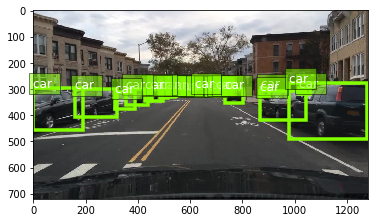

In [3]:
dataset = gcv.data.RecordFileDetection('../data/highway_vehicle/train.rec')
valdataset = gcv.data.RecordFileDetection('../data/highway_vehicle/val.rec')
testdataset = gcv.data.RecordFileDetection('../data/highway_vehicle/test.rec')

classes = ["truck", "car", "van", "bus"]
image, label = valdataset[1410]
print('label:', label)
# display image and label
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
plt.show()

In [6]:
net = gcv.model_zoo.get_model('yolo3_mobilenet0.25_custom', classes=classes,
    pretrained_base=True)#, transfer='coco')
net.initialize(init=init.Xavier())

/home/zwmao/.local/lib/python3.5/site-packages/mxnet/gluon/parameter.py:862: UserWarning: Parameter 'mobilenet2_conv0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/zwmao/.local/lib/python3.5/site-packages/mxnet/gluon/parameter.py:862: UserWarning: Parameter 'mobilenet2_batchnorm0_gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/zwmao/.local/lib/python3.5/site-packages/mxnet/gluon/parameter.py:862: UserWarning: Parameter 'mobilenet2_batchnorm0_beta' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/zwmao/.local/lib/python3.5/site-packages/mxnet/gluon/parameter.py:862: UserWarning: Parameter 'mobilenet2_batchnorm0_running_mean' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.i

In [5]:
net = gcv.model_zoo.get_model('yolo3_mobilenet0.25_custom', classes=classes,
    pretrained_base=False)#, transfer='coco')
net.load_parameters("mobilenet0.25_yolo3_highway_0106_0.5997.params")

MXNetError: [05:23:32] src/io/local_filesys.cc:209: Check failed: allow_null:  LocalFileSystem::Open "mobilenet0.25_yolo3_highway_0106_0.5997.params": No such file or directory
Stack trace:
  [bt] (0) /home/zwmao/.local/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x2fd5d88) [0x7fed1f9c1d88]
  [bt] (1) /home/zwmao/.local/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x2fcd95a) [0x7fed1f9b995a]
  [bt] (2) /home/zwmao/.local/lib/python3.5/site-packages/mxnet/libmxnet.so(MXNDArrayLoad+0x23d) [0x7fed1efb213d]
  [bt] (3) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(ffi_call_unix64+0x4c) [0x7fee0d55be20]
  [bt] (4) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(ffi_call+0x2eb) [0x7fee0d55b88b]
  [bt] (5) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(_ctypes_callproc+0x49a) [0x7fee0d55601a]
  [bt] (6) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(+0x9fcb) [0x7fee0d549fcb]
  [bt] (7) /usr/bin/python3(PyObject_Call+0x47) [0x5bc037]
  [bt] (8) /usr/bin/python3(PyEval_EvalFrameEx+0x4f0f) [0x528cef]



In [7]:
def get_dataloader(net, train_dataset, val_dataset, test_dataset, data_shape, batch_size, num_workers, no_random_shape):
    """Get dataloader."""
    width, height = data_shape, data_shape
    batchify_fn = Tuple(*([Stack() for _ in range(6)] + [Pad(axis=0, pad_val=-1) for _ in range(1)]))  # stack image, all targets generated
    if no_random_shape:
        train_loader = gluon.data.DataLoader(
            train_dataset.transform(YOLO3DefaultTrainTransform(width, height, net)),
            batch_size, True, batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
    else:
        transform_fns = [YOLO3DefaultTrainTransform(x * 32, x * 32, net) for x in range(8, 14)]
        train_loader = RandomTransformDataLoader(
            transform_fns, train_dataset, batch_size=batch_size, interval=10, last_batch='rollover',
            shuffle=True, batchify_fn=batchify_fn, num_workers=num_workers)
    
    val_batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
    
    val_loader = gluon.data.DataLoader(
        val_dataset.transform(YOLO3DefaultValTransform(width, height)),
        batch_size, False, batchify_fn=val_batchify_fn, last_batch='keep', num_workers=num_workers)
    
    test_loader = gluon.data.DataLoader(
        test_dataset.transform(YOLO3DefaultValTransform(width, height)),
        batch_size, False, batchify_fn=val_batchify_fn, last_batch='keep', num_workers=num_workers)
    return train_loader, val_loader, test_loader

data_shape = 320
train_data, val_data, test_data = get_dataloader(net, dataset, valdataset, testdataset, data_shape, 32, 32, False)

In [8]:
ctx = [mx.gpu(0), mx.gpu(1)]

In [9]:
def train(val_metric=val_metric):
    net.collect_params().reset_ctx(ctx)
    if True:#turn on no-wd for bias
        for k, v in net.collect_params('.*beta|.*gamma|.*bias').items():
            v.wd_mult = 0.0

    if True:#turn on label smoothing
        net._target_generator._label_smooth = True

    if 0 > 0:#turn off lr_decay_period
        lr_decay_epoch = list(range(lr_decay_period, epochs, lr_decay_period))
    else:
        lr_decay_epoch = "130,170"#set lr-decay epoch
        lr_decay_epoch = [int(i) for i in lr_decay_epoch.split(',')]
        
    val_metric
    warmup_epochs = 2
    num_samples = len(dataset)
    batch_size = 32
    lr_decay = 0.1
    epochs = 200
    
    lr_decay_epoch = [e - warmup_epochs for e in lr_decay_epoch]
    num_batches = num_samples // batch_size
    lr_scheduler = LRSequential([
        LRScheduler('linear', base_lr=0, target_lr=0.001,
                    nepochs=warmup_epochs, iters_per_epoch=num_batches),
        LRScheduler('step', base_lr=0.001,
                    nepochs=epochs - warmup_epochs,
                    iters_per_epoch=num_batches,
                    step_epoch=lr_decay_epoch,
                    step_factor=lr_decay, power=2),
    ])

    trainer = gluon.Trainer(
        net.collect_params(), 'sgd',
        {'wd': 0.0005, 'momentum': 0.9, 'lr_scheduler': lr_scheduler},
        kvstore='local')
    
    sigmoid_ce = gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
    l1_loss = gluon.loss.L1Loss()

    # metrics
    obj_metrics = mx.metric.Loss('ObjLoss')
    center_metrics = mx.metric.Loss('BoxCenterLoss')
    scale_metrics = mx.metric.Loss('BoxScaleLoss')
    cls_metrics = mx.metric.Loss('ClassLoss')

    # set up logger
    #logging.basicConfig()
    #logger = logging.getLogger()
    #logger.setLevel(logging.INFO)
    #log_file_path = args.save_prefix + '_train.log'
    #log_dir = os.path.dirname(log_file_path)
    #if log_dir and not os.path.exists(log_dir):
     #   os.makedirs(log_dir)
    #fh = logging.FileHandler(log_file_path)
    #logger.addHandler(fh)
    #logger.info(args)
    #logger.info('Start training from [Epoch {}]'.format(args.start_epoch))
    best_map = [0]
    for epoch in range(0, epochs):
        #if args.mixup:
            # TODO(zhreshold): more elegant way to control mixup during runtime
         #   try:
          #      train_data._dataset.set_mixup(np.random.beta, 1.5, 1.5)
           # except AttributeError:
        #        train_data._dataset._data.set_mixup(np.random.beta, 1.5, 1.5)
            #if epoch >= args.epochs - args.no_mixup_epochs:
             #   try:
              #      train_data._dataset.set_mixup(None)
               # except AttributeError:
                #    train_data._dataset._data.set_mixup(None)

        tic = time.time()
        btic = time.time()
        mx.nd.waitall()
        net.hybridize()
        for i, batch in enumerate(train_data):
            batch_size = batch[0].shape[0]
            data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
            # objectness, center_targets, scale_targets, weights, class_targets
            fixed_targets = [gluon.utils.split_and_load(batch[it], ctx_list=ctx, batch_axis=0) for it in range(1, 6)]
            gt_boxes = gluon.utils.split_and_load(batch[6], ctx_list=ctx, batch_axis=0)
            sum_losses = []
            obj_losses = []
            center_losses = []
            scale_losses = []
            cls_losses = []
            with autograd.record():
                for ix, x in enumerate(data):
                    obj_loss, center_loss, scale_loss, cls_loss = net(x, gt_boxes[ix], *[ft[ix] for ft in fixed_targets])
                    sum_losses.append(obj_loss + center_loss + scale_loss + cls_loss)
                    obj_losses.append(obj_loss)
                    center_losses.append(center_loss)
                    scale_losses.append(scale_loss)
                    cls_losses.append(cls_loss)
                autograd.backward(sum_losses)
            trainer.step(batch_size)
            obj_metrics.update(0, obj_losses)
            center_metrics.update(0, center_losses)
            scale_metrics.update(0, scale_losses)
            cls_metrics.update(0, cls_losses)
            if not (i + 1) % 50:
                name1, loss1 = obj_metrics.get()
                name2, loss2 = center_metrics.get()
                name3, loss3 = scale_metrics.get()
                name4, loss4 = cls_metrics.get()
                print('[Epoch {}][Batch {}], LR: {:.2E}, Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}'.format(
                    epoch, i, trainer.learning_rate, batch_size/(time.time()-btic), name1, loss1, name2, loss2, name3, loss3, name4, loss4))
            btic = time.time()

        name1, loss1 = obj_metrics.get()
        name2, loss2 = center_metrics.get()
        name3, loss3 = scale_metrics.get()
        name4, loss4 = cls_metrics.get()
        print('[Epoch {}] Training cost: {:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}'.format(
            epoch, (time.time()-tic), name1, loss1, name2, loss2, name3, loss3, name4, loss4))
        if not (epoch + 1) % 1:
            # consider reduce the frequency of validation to save time
            map_name, mean_ap = validate(net, val_data, ctx, val_metric)
            val_msg = '\n'.join(['{}={}'.format(k, v) for k, v in zip(map_name, mean_ap)])
            print('[Epoch {}] Validation: \n{}'.format(epoch, val_msg))
            current_map = float(mean_ap[-1])
            
            map_name, mean_ap = validate(net, test_data, ctx, val_metric)
            test_msg = '\n'.join(['{}={}'.format(k, v) for k, v in zip(map_name, mean_ap)])
            print('[Epoch {}] Test: \n{}'.format(epoch, test_msg))
        else:
            current_map = 0.
        
        save_interval = 2
        save_prefix = 'm0.25_yolo3_highway'

        save_params(net, best_map, current_map, epoch, save_interval, save_prefix)

In [ ]:
train()

[Epoch 0][Batch 49], LR: 5.04E-05, Speed: 83.973 samples/sec, ObjLoss=682.637, BoxCenterLoss=18.945, BoxScaleLoss=21.466, ClassLoss=15.286
[Epoch 0][Batch 99], LR: 1.01E-04, Speed: 166.393 samples/sec, ObjLoss=357.591, BoxCenterLoss=17.934, BoxScaleLoss=17.034, ClassLoss=11.963
[Epoch 0][Batch 149], LR: 1.51E-04, Speed: 90.943 samples/sec, ObjLoss=247.925, BoxCenterLoss=17.354, BoxScaleLoss=14.577, ClassLoss=10.176
[Epoch 0][Batch 199], LR: 2.01E-04, Speed: 68.579 samples/sec, ObjLoss=192.564, BoxCenterLoss=17.086, BoxScaleLoss=13.128, ClassLoss=9.076
[Epoch 0][Batch 249], LR: 2.52E-04, Speed: 54.823 samples/sec, ObjLoss=158.836, BoxCenterLoss=16.730, BoxScaleLoss=12.070, ClassLoss=8.328
[Epoch 0][Batch 299], LR: 3.02E-04, Speed: 99.511 samples/sec, ObjLoss=136.151, BoxCenterLoss=16.502, BoxScaleLoss=11.331, ClassLoss=7.826
[Epoch 0][Batch 349], LR: 3.52E-04, Speed: 69.126 samples/sec, ObjLoss=119.916, BoxCenterLoss=16.355, BoxScaleLoss=10.811, ClassLoss=7.437
[Epoch 0][Batch 399], LR:

[Epoch 5][Batch 149], LR: 1.00E-03, Speed: 83.942 samples/sec, ObjLoss=31.567, BoxCenterLoss=15.003, BoxScaleLoss=6.601, ClassLoss=5.060
[Epoch 5][Batch 199], LR: 1.00E-03, Speed: 38.763 samples/sec, ObjLoss=31.284, BoxCenterLoss=14.997, BoxScaleLoss=6.575, ClassLoss=5.050
[Epoch 5][Batch 249], LR: 1.00E-03, Speed: 51.345 samples/sec, ObjLoss=31.016, BoxCenterLoss=14.989, BoxScaleLoss=6.548, ClassLoss=5.040
[Epoch 5][Batch 299], LR: 1.00E-03, Speed: 58.445 samples/sec, ObjLoss=30.733, BoxCenterLoss=14.968, BoxScaleLoss=6.526, ClassLoss=5.027
[Epoch 5][Batch 349], LR: 1.00E-03, Speed: 95.679 samples/sec, ObjLoss=30.489, BoxCenterLoss=14.970, BoxScaleLoss=6.507, ClassLoss=5.020
[Epoch 5][Batch 399], LR: 1.00E-03, Speed: 34.868 samples/sec, ObjLoss=30.248, BoxCenterLoss=14.961, BoxScaleLoss=6.483, ClassLoss=5.009
[Epoch 5][Batch 449], LR: 1.00E-03, Speed: 73.460 samples/sec, ObjLoss=29.989, BoxCenterLoss=14.944, BoxScaleLoss=6.461, ClassLoss=4.999
[Epoch 5] Training cost: 242.861, ObjLoss

/home/zwmao/.local/lib/python3.5/site-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


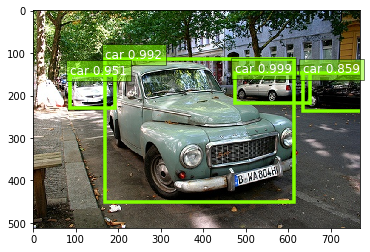

In [4]:
classes = ["truck", "car", "van", "bus"]
net = gcv.model_zoo.get_model('yolo3_mobilenet1.0_custom', classes=classes, pretrained_base=False)
net.load_parameters('ssd_512_mobilenet1.0_highway-48.params')
x, image = gcv.data.transforms.presets.ssd.load_test('../ssd/000152.jpg', 512)
cid, score, bbox = net(x.as_in_context(mx.cpu(0)))
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes)
plt.show()

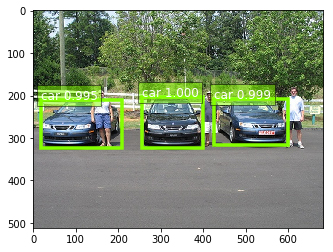

In [5]:
x, image = gcv.data.transforms.presets.ssd.load_test('../ssd/002446.jpg', 512)
cid, score, bbox = net(x.as_in_context(mx.cpu(0)))
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes,)
plt.show()

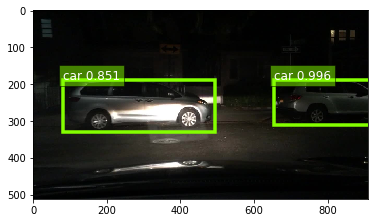

In [8]:
x, image = gcv.data.transforms.presets.ssd.load_test('../data/highway_vehicle/JPEGImages/c5343589-f0a9e124.jpg', 512)
cid, score, bbox = net(x.as_in_context(mx.cpu(0)))
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes,)
plt.show()

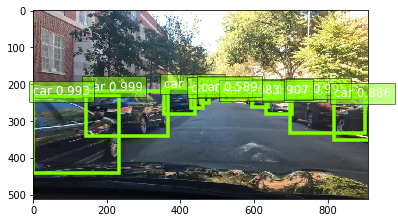

In [7]:
x, image = gcv.data.transforms.presets.ssd.load_test('../data/highway_vehicle/JPEGImages/ca1543ec-4ef9d107.jpg', 512)
cid, score, bbox = net(x.as_in_context(mx.cpu(0)))
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes)
plt.show()